# Time-dependent ROC

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import auc
from lifelines import KaplanMeierFitter, CoxPHFitter

Read the data

In [2]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Survival of multiple myeloma patients.dat", sep="\s+")
DatOriginal = DatOriginal.drop('patient', axis=1)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3688/843039072.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Survival of multiple myeloma patients.dat", sep="\s+")


In [3]:
Model = CoxPHFitter().fit(DatOriginal, "time", "status", formula="bun+hb")
LogPartialHazard = Model.predict_log_partial_hazard(DatOriginal)
RiskScores = LogPartialHazard.sort_values()

KM = KaplanMeierFitter()
KM.fit(DatOriginal['time'], DatOriginal['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 48 total observations, 12 right-censored observations>

In [4]:
def TimeDependROC(t):
    sens_list = []
    spec_list = []

    for c in RiskScores[:-1]:

        Dat1 = DatOriginal[LogPartialHazard>c]
        km1 = KaplanMeierFitter()
        km1.fit(Dat1['time'], Dat1['status'])

        Dat2 = DatOriginal[LogPartialHazard<=c]
        km2 = KaplanMeierFitter()
        km2.fit(Dat2['time'], Dat2['status'])

        p = len(Dat2) / len(DatOriginal)
        Surv_t = KM.survival_function_at_times(t)

        sens = (1 - km1.survival_function_at_times(t)) * (1-p) / (1-Surv_t)
        spec = km2.survival_function_at_times(t) * p / Surv_t

        sens_list.append(sens.values[0])
        spec_list.append(spec.values[0])

    sens_list = np.array(sens_list)
    spec_list = np.array(spec_list)

    roc = pd.DataFrame({'Sens': sens_list, 'Spec':spec_list})

    roc.loc[roc['Sens']<0, 'Sens'] = 0
    roc.loc[roc['Sens']>1, 'Sens'] = 1

    roc.loc[roc['Spec']<0, 'Spec'] = 0
    roc.loc[roc['Spec']>1, 'Spec'] = 1

    roc['1-Spec'] = 1-roc['Spec']
    roc = roc.sort_values('1-Spec').reset_index(drop=True)

    return roc

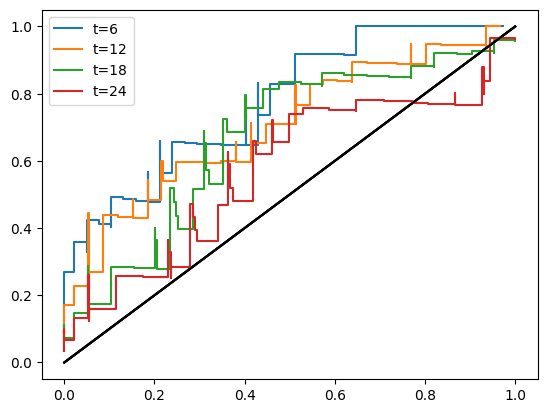

In [5]:
Times = [6,12,18,24]

Auc_list = []

for t in Times:
    Roc = TimeDependROC(t)

    Auc_list.append(auc(Roc['1-Spec'], Roc['Sens']))

    plt.step(Roc['1-Spec'], Roc['Sens'], where='post', label="t={}".format(t))
    plt.plot([0,1], [0,1], color='k')
    plt.legend()

Auc = pd.DataFrame({'AUC':Auc_list}, index=Times)

In [6]:
Auc.round(4)

,AUC
6,0.7553
12,0.6883
18,0.6844
24,0.5954
